In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plts

In [2]:
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('Waste.csv')
df.head()

,GDP,Metal,Others,Population,Electronic tons,Hazardous tons,Total MSW,GDP Per Capita,Unit Per Capita,Organic,Glass,Paper/Carboard,Plastic,Treatment/Recycling,Info System,Agency,Law,PPP
0,21.193311,1.722767,3.047692,11.544298,6.551080,6.921987,11.386591,9.649013,-9.806720,25.466667,5.900000,22.000000,11.300000,11.000000,1,1,1,1
1,23.787293,1.061257,2.567766,17.360982,9.903488,12.437678,15.543358,6.426310,-8.243935,49.746667,3.903333,16.436667,12.276667,25.530000,1,1,1,1
2,25.358406,1.481605,2.442347,17.038225,11.429544,12.437678,15.253838,8.320181,-10.104567,51.800000,6.700000,11.900000,13.500000,25.530000,1,1,1,1
3,23.323811,1.568616,2.721953,14.873545,9.903488,8.650818,13.949135,8.450266,-9.374676,51.400000,4.500000,9.900000,9.600000,35.200000,0,1,1,0
4,21.923195,0.955511,2.451005,11.319717,6.141636,7.488853,10.668955,10.603478,-11.254239,31.200000,8.200000,35.100000,11.300000,24.333333,1,1,1,1


In [6]:
# Calculate the Quartiles and the Inter Quartile Range (IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Defining the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Reducing the outliers to lower and upper bounds
data_clipped = df.clip(lower=lower_bound, upper=upper_bound, axis=1)

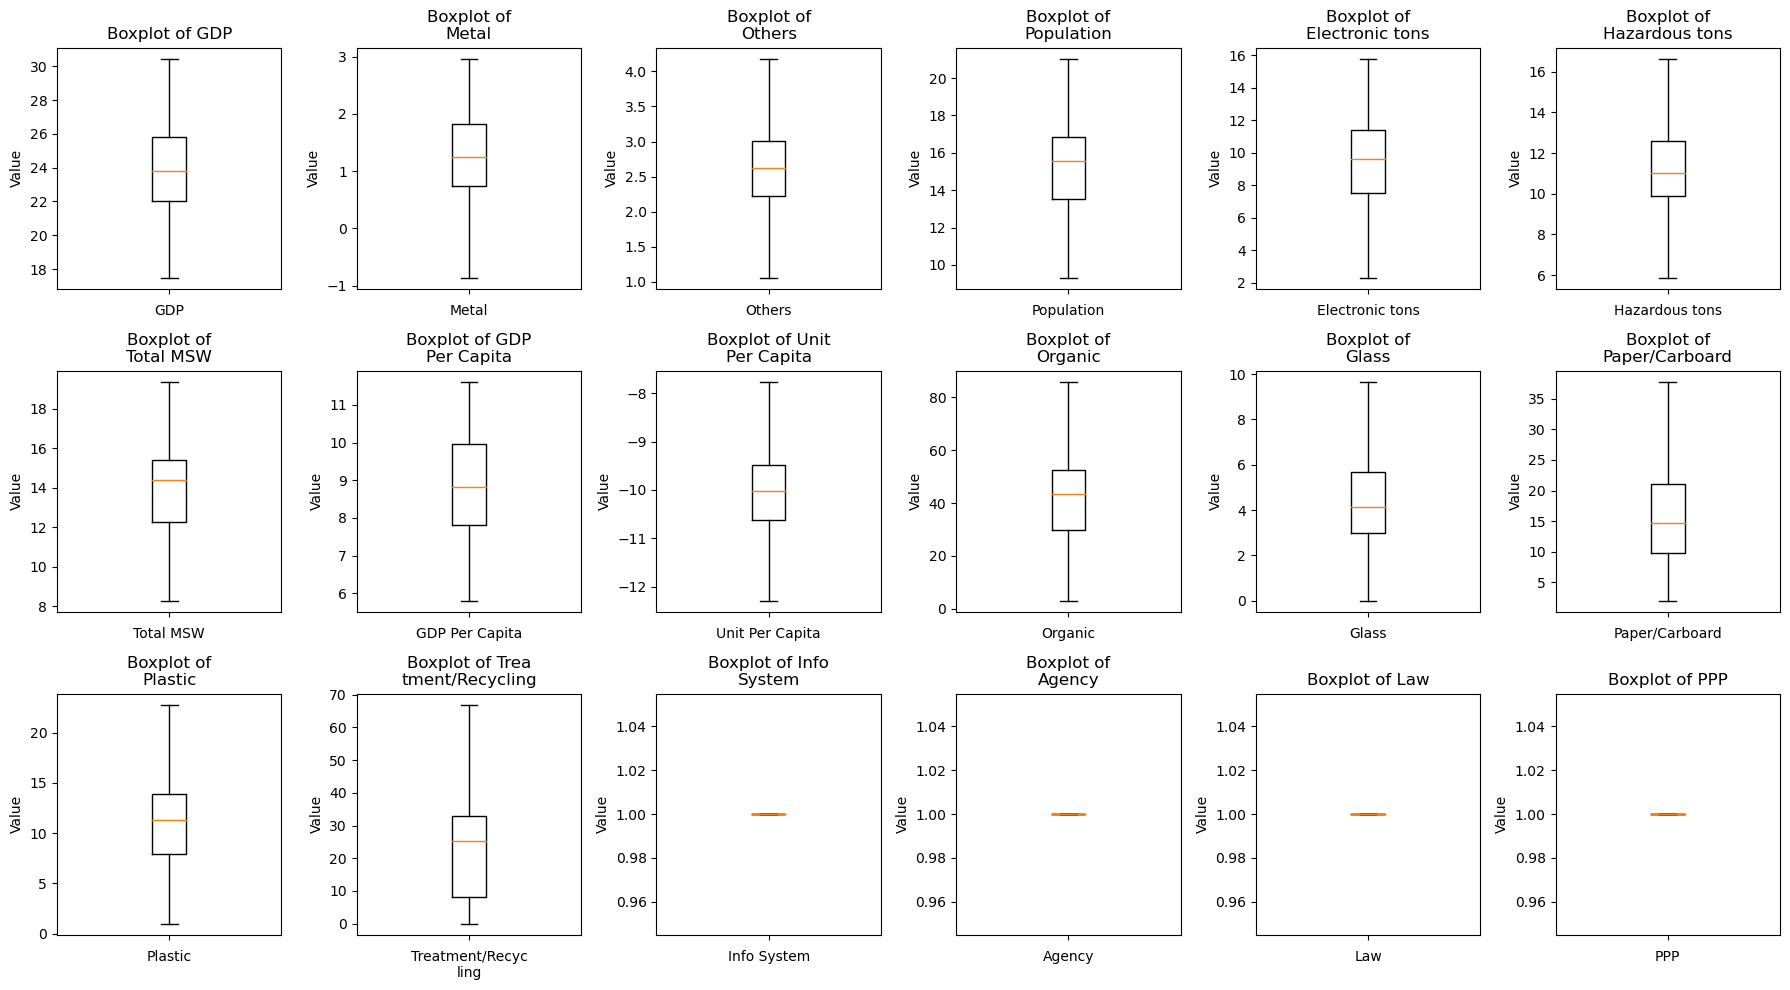

In [7]:
import textwrap
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'trimmed_data' with the columns you want to plot

# Create subplots
fig, axes = plt.subplots(3, 6, figsize=(18, 10))  # Adjust the size as needed
axes = axes.flatten()

# Plot boxplots on the subplots
for i, column in enumerate(data_clipped.columns[:18]):
    wrapped_title = "\n".join(textwrap.wrap(f'Boxplot of {column}', width=15))
    wrapped_col = "\n".join(textwrap.wrap(f'{column}', width=15))
    axes[i].boxplot(data_clipped[column].dropna())
    axes[i].set_title(f'{wrapped_title}')
    axes[i].set_xlabel(wrapped_col)
    axes[i].set_ylabel('Value')

    # Remove x-axis ticks
    axes[i].set_xticklabels([])

# Remove the last unused subplots
for i in range(18, len(axes)):
    fig.delaxes(axes[i])

# Save the scatter plot as an image file (e.g., PNG, PDF, SVG)
#plt.savefig('boxplot.png')

# Adjust layout
plt.tight_layout()
plt.show()


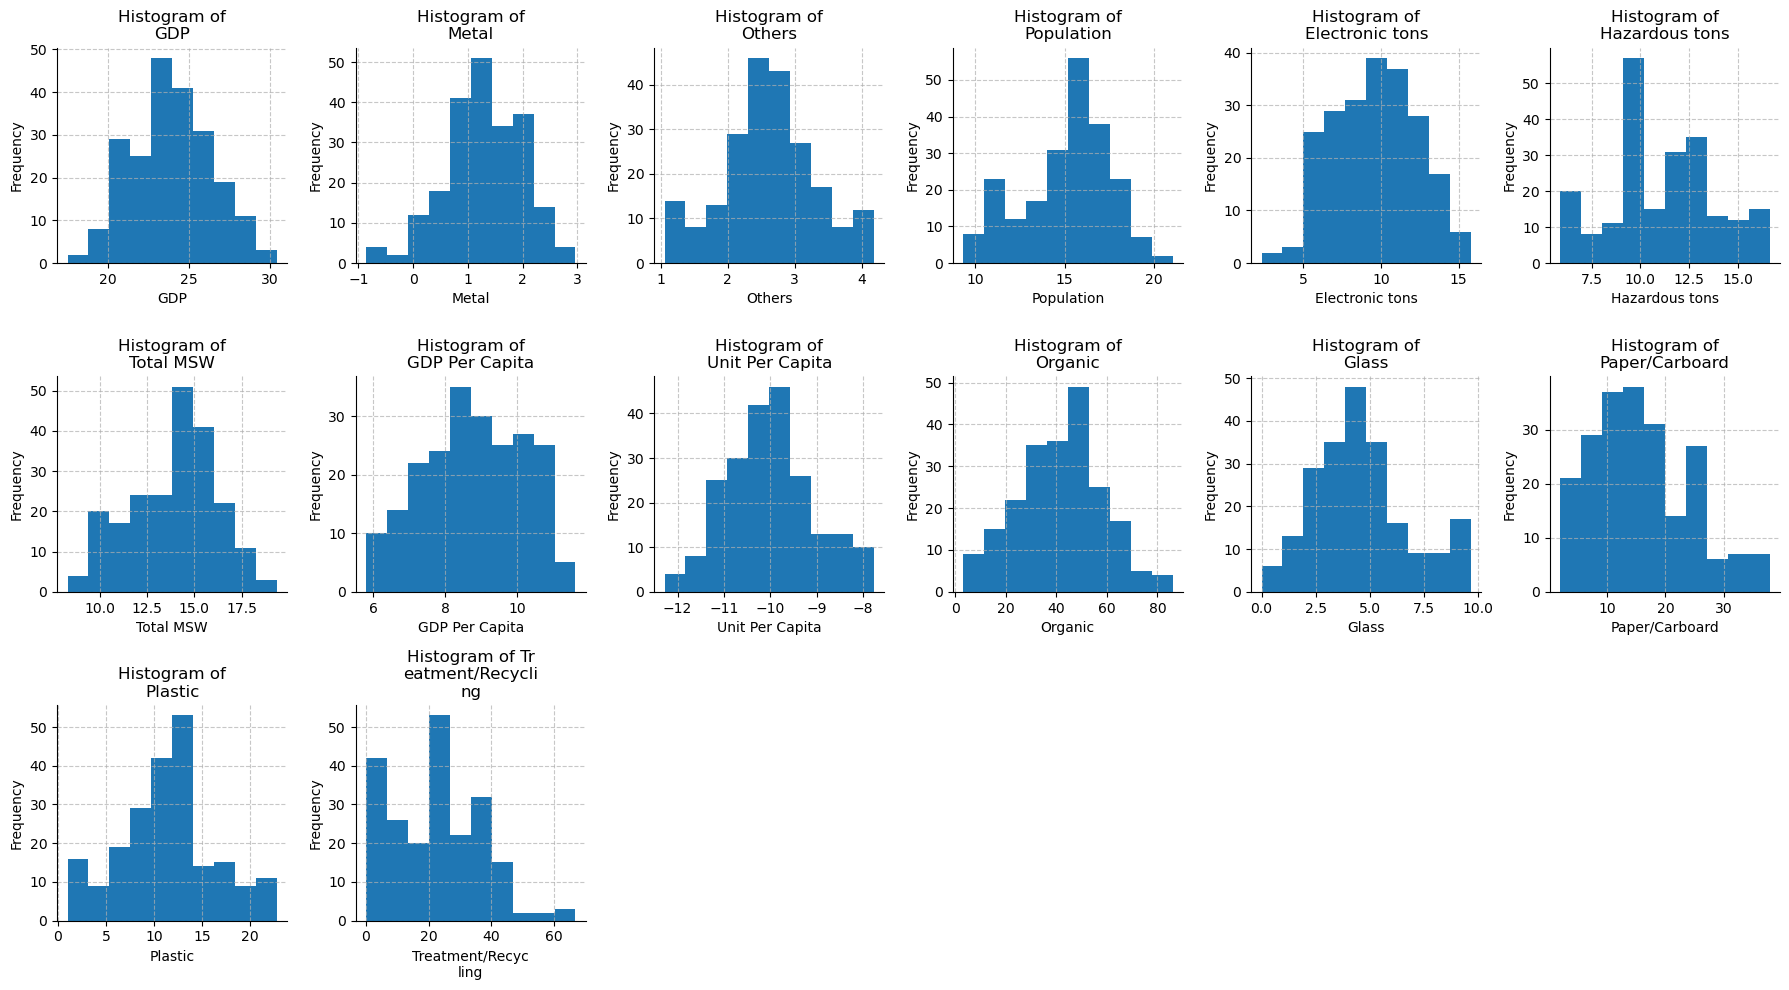

In [17]:
fig, axes = plt.subplots(nrows=3,ncols=6, figsize=(18,10))
axes = axes.flatten()
for i, column in enumerate(data_clipped[:14]):
    if i<14:
        
        wrapped_title = "\n".join(textwrap.wrap(f'Histogram of {column}', width=15))
        wrapped_col = "\n".join(textwrap.wrap(f'{column}', width=15))
        axes[i].hist(data_clipped[column])
        axes[i].grid(True, linestyle='--', alpha=0.7)
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].set_title(f'{wrapped_title}')
        axes[i].set_xlabel(wrapped_col)
        axes[i].set_ylabel('Frequency')
for i in range(14, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# Save the scatter plot as an image file (e.g., PNG, PDF, SVG)
#plt.savefig('Histogram2_plot.png', dpi=300)
plt.show()

In [33]:

X = data_clipped[['GDP','Population', 'Hazardous tons', 'Electronic tons']]
y = data_clipped['Total MSW']
y.dtypes

dtype('float64')

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [45]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,y)
yp = lm.predict([[2,1,3,4]])
yp

array([17.27339028])

In [46]:
import pickle

In [76]:
data = {'model': lm}
with open('saved.pkl', 'wb') as file:
    pickle.dump(data, file)

In [77]:
with open('saved.pkl', 'rb') as file:
    data = pickle.load(file)

lm2 = data['model']

In [78]:
lm2.predict([[2,1,3,4]])

array([17.27339028])

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from keras.layers import Dropout
from sklearn.model_selection import ParameterGrid
from keras.models import Sequential
from keras.layers import Dense

In [62]:
def create_ann_model(neurons=1, hidden_layers=1, learning_rate=0.01, optimizer='adam', dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout to the input layer
    
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))  # Add dropout to hidden layers
    
    model.add(Dense(1, activation='linear'))  
    
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    
    return model
param_grid = {
    'neurons': [8, 16, 32],
    'hidden_layers': [1, 2, 3],
    'learning_rate': [0.001, 0.01, 0.1],
    'optimizer': ['adam', 'sgd'],
    'dropout_rate': [0.0, 0.2, 0.5]
}
best_params = None
best_mse = float('inf')
best_model = None
best_history = None
for params in ParameterGrid(param_grid):
    ann_model = create_ann_model(**params)
    history = ann_model.fit(X, y, validation_split=0.2, epochs=20, verbose=0)
    
   
    y_pred_ann = ann_model.predict(X)
    mse_ann_test = mean_squared_error(y, y_pred_ann)
    
    if mse_ann_test < best_mse:
        best_mse = mse_ann_test
        best_params = params
        best_model = ann_model
        best_history = history

7/7 [==============================] - 0s 2ms/step


7/7 [==============================] - 0s 2ms/step


In [65]:
best_model.predict([[2,1,3,4]])

1/1 [==============================] - 0s 168ms/step


array([[20.194368]], dtype=float32)

In [73]:
data = {'model': best_model}
with open('saved2.pkl', 'wb') as file:
    pickle.dump(data, file)

In [74]:
with open('saved2.pkl', 'rb') as file:
    data = pickle.load(file)

ann = data['model']

In [75]:
ann.predict([[2,1,3,4]])

1/1 [==============================] - 0s 158ms/step


array([[20.194368]], dtype=float32)